<a href="https://colab.research.google.com/github/0zan0zer/Financial/blob/Machine-Learning/Financial_Indicators_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing packages**

In [ ]:
!pip install python-binance
!pip install catboost
!pip install matplotlib==3.1.3
!pip install mplfinance

     |████████████████████████████████| 58 kB 2.5 MB/s 
     |████████████████████████████████| 103 kB 8.9 MB/s 
     |████████████████████████████████| 1.3 MB 9.2 MB/s 
     |████████████████████████████████| 279 kB 22.1 MB/s 
     |████████████████████████████████| 179 kB 23.2 MB/s 
     |████████████████████████████████| 142 kB 26.3 MB/s 
     |████████████████████████████████| 294 kB 27.9 MB/s 
     |████████████████████████████████| 69.2 MB 4.7 kB/s 
     |████████████████████████████████| 13.1 MB 86 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 62 kB 727 kB/s 


In [ ]:
import pandas as pd
import numpy as np

import time
import dateparser
import pytz
import json

import math  

import datetime as dt
from datetime import datetime, timedelta

from threading import Thread

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

import mplfinance as mpf

%matplotlib inline

import sys



from sklearn import preprocessing, model_selection, neighbors, svm
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

from tqdm import tqdm as tqdm

from binance.client import Client

# **Functions of Indicators**

In [ ]:
def moving_average(df, n):
  MA = pd.Series(df["Close"].rolling(n, min_periods = n).mean(), name="MA_" + str(n))
  df = df.join(MA)
  return df

In [ ]:
def exponential_moving_average(df, n):
  EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
  df = df.join(EMA)
  return df

In [ ]:
def momentum(df, n):
  M = pd.Series(df["Close"].diff(n), name="Momentum_" + str(n))
  df = df.join(M)
  return df

In [ ]:
def bollinger_bands(df, n):
  MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
  MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
  b1 = 4 * MSD / MA
  B1 = pd.Series(b1, name = "BollingerB_" + str(n))
  df = df.join(B1)
  b2 = (df['Close'] - MA  + 2 * MSD) / (4 * MSD)
  B2 = pd.Series(b2, name='Bollinger%b_'+str(n))
  df = df.join(B2)
  return df

In [ ]:
def stochastic_oscillator(df ,n):
  S0K = pd.Series((df['Close']- df['Low']) / (df['High']-df['Low']), name='S0k_' + str(n))
  df = df.join(S0K)
  return df

In [ ]:
def relative_strength_index(df, n):
  i = 0
  UpI = [0]
  DoI = [0]

  while i + 1 <= df.index[-1]:
    UpMove = df.loc[i+1, 'High'] - df.loc[i, 'High']
    DoMove = df.loc[i+1, 'Low'] - df.loc[i, 'Low']
    if UpMove > DoMove and UpMove > 0:
      UpD = UpMove
    else:
      UpD = 0
    UpI.append(UpD)
    if DoMove > UpMove and DoMove > 0:
      DoD = DoMove
    else:
      DoD = 0
    DoI.append(DoD)
    i = i + 1

  UpI = pd.Series(UpI)
  DoI = pd.Series(DoI)
  PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
  NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
  RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
  df = df.join(RSI)
  return df

In [ ]:
def common_channel_index(df, n):
  PP = (df['High'] + df['Low'] + df['Close']) / 3
  CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(), name='CCI_' + str(n))
  df = df.join(CCI)
  return df

In [ ]:
def standart_deviation(df, n):
  df = df.join(pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n)))
  return df

In [ ]:
def MOST(df, n , p):

  EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
  df = df.join(EMA)

  p = p / 100
  previous_final_upperband = 0
  previous_final_lowerband = 0
  final_upperband = 0
  final_lowerband = 0
  previous_close = 0
  previous_most = 0
  most = []
  mostc = 0

  for i in range(0, len(df['Close'])):
        if np.isnan(df['Close'][i]):
            pass
        else:
            emac = df['EMA_' + str(n)][i]
            closec = df['Close'][i]

            basic_upperband = emac + emac * p
            basic_lowerband = emac - emac * p

            if basic_upperband < previous_final_upperband or previous_close > previous_final_upperband:
                final_upperband = basic_upperband
            else:
                final_upperband = previous_final_upperband

            if basic_lowerband > previous_final_lowerband or previous_close < previous_final_lowerband:
                final_lowerband = basic_lowerband
            else:
                final_lowerband = previous_final_lowerband

            if previous_most == previous_final_upperband and closec <= final_upperband:
                mostc = final_upperband
            else:
                if previous_most == previous_final_upperband and closec >= final_upperband:
                    mostc = final_lowerband
                else:
                    if previous_most == previous_final_lowerband and closec >= final_lowerband:
                        mostc = final_lowerband
                    elif previous_most == previous_final_lowerband and closec <= final_lowerband:
                        mostc = final_upperband

            most.append(mostc)

            previous_close = closec

            previous_final_upperband = final_upperband

            previous_final_lowerband = final_lowerband

            previous_most = mostc

  most = np.array(most)
  most = pd.Series(most, name = "Most_" + str(n))
  df = df.join(most)


  return df

In [ ]:
def eMost(df, n, p):
  EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
  df = df.join(EMA)

  p = p / 100
  previous_final_upperband = 100000
  previous_final_lowerband = 0.0
  final_upperband = 0
  final_lowerband = 0
  previous_close = 0
  previous_most = 0
  most = []
  mostc = 0
  lb = []
  ub = []
  for i in range(0, len(df['Close'])):
    if np.isnan(df['EMA_' + str(n)][i]):
      pass
    else:
      emac = df['EMA_' + str(n)][i]
      closec = df['Close'][i]


      basic_upperband = emac + emac * p
      basic_lowerband = emac - emac * p

      if basic_upperband < previous_final_upperband or previous_close > previous_final_upperband:
          final_upperband = basic_upperband
      else:
          final_upperband = previous_final_upperband

      if basic_lowerband > previous_final_lowerband or previous_close < previous_final_lowerband:
          final_lowerband = basic_lowerband
      else:
          final_lowerband = previous_final_lowerband

     
    lb.append(final_lowerband)
    ub.append(final_upperband)

  lb = np.array(lb)
  for key,i in enumerate(lb):
    if i == 0:
      lb[key] = np.nan
  lb = pd.Series(lb, name = "LBand")
  df = df.join(lb)

  ub = np.array(ub)
  for key,i in enumerate(ub):
    if i == 0:
      ub[key] = np.nan
  ub = pd.Series(ub, name = "UBand")
  df = df.join(ub)

  most = np.array(most)
  most = pd.Series(most, name = "Most_" + str(n))
  df = df.join(most)

  return df

In [ ]:
def Supertrend(df, n, atr_multiplier):

    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)

    atr = true_range.rolling(n).sum()/n
    atr = pd.Series(atr, name = "ATR_" + str(n))
    df = df.join(atr)

    previous_final_upperband = 0
    previous_final_lowerband = 0
    final_upperband = 0
    final_lowerband = 0
    previous_close = 0
    previous_supertrend = 0
    supertrend = []
    supertrendc = 0

    for i in range(0, len(df['Close'])):
        if np.isnan(df['Close'][i]):
            pass
        else:
            highc = df['High'][i]
            lowc = df['Low'][i]
            atrc = df['ATR_' + str(n)][i]
            closec = df['Close'][i]

            if math.isnan(atrc):
                atrc = 0

            basic_upperband = (highc + lowc) / 2 + atr_multiplier * atrc
            basic_lowerband = (highc + lowc) / 2 - atr_multiplier * atrc

            if basic_upperband < previous_final_upperband or previous_close > previous_final_upperband:
                final_upperband = basic_upperband
            else:
                final_upperband = previous_final_upperband

            if basic_lowerband > previous_final_lowerband or previous_close < previous_final_lowerband:
                final_lowerband = basic_lowerband
            else:
                final_lowerband = previous_final_lowerband

            if previous_supertrend == previous_final_upperband and closec <= final_upperband:
                supertrendc = final_upperband
            else:
                if previous_supertrend == previous_final_upperband and closec >= final_upperband:
                    supertrendc = final_lowerband
                else:
                    if previous_supertrend == previous_final_lowerband and closec >= final_lowerband:
                        supertrendc = final_lowerband
                    elif previous_supertrend == previous_final_lowerband and closec <= final_lowerband:
                        supertrendc = final_upperband

            supertrend.append(supertrendc)

            previous_close = closec

            previous_final_upperband = final_upperband

            previous_final_lowerband = final_lowerband

            previous_supertrend = supertrendc

    supertrend = np.array(supertrend)
    supertrend = pd.Series(supertrend, name = "Supertrend")
    df = df.join(supertrend)


    return df

In [ ]:
def eSupertrend(df, n, atr_multiplier):

    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)

    atr = true_range.rolling(n).sum()/n
    atr = pd.Series(atr, name = "ATR_" + str(n))
    df = df.join(atr)

    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
    df = df.join(EMA)

    previous_final_upperband = 0
    previous_final_lowerband = 0
    final_upperband = 0
    final_lowerband = 0
    previous_close = 0
    previous_supertrend = 0
    supertrend = []
    supertrendc = 0

    for i in range(0, len(df['Close'])):
        if np.isnan(df['Close'][i]):
            pass
        else:
            emac = df['EMA_' + str(n)][i]
            atrc = df['ATR_' + str(n)][i]
            closec = df['Close'][i]

            if math.isnan(atrc):
                atrc = 0

            basic_upperband = emac + atr_multiplier * atrc
            basic_lowerband = emac - atr_multiplier * atrc

            if basic_upperband < previous_final_upperband or previous_close > previous_final_upperband:
                final_upperband = basic_upperband
            else:
                final_upperband = previous_final_upperband

            if basic_lowerband > previous_final_lowerband or previous_close < previous_final_lowerband:
                final_lowerband = basic_lowerband
            else:
                final_lowerband = previous_final_lowerband

            if previous_supertrend == previous_final_upperband and closec <= final_upperband:
                supertrendc = final_upperband
            else:
                if previous_supertrend == previous_final_upperband and closec >= final_upperband:
                    supertrendc = final_lowerband
                else:
                    if previous_supertrend == previous_final_lowerband and closec >= final_lowerband:
                        supertrendc = final_lowerband
                    elif previous_supertrend == previous_final_lowerband and closec <= final_lowerband:
                        supertrendc = final_upperband

            supertrend.append(supertrendc)

            previous_close = closec

            previous_final_upperband = final_upperband

            previous_final_lowerband = final_lowerband

            previous_supertrend = supertrendc

    supertrend = np.array(supertrend)
    supertrend = pd.Series(supertrend, name = "Supertrend")
    df = df.join(supertrend)


    return df

In [ ]:
def atr(df, n):
  high_low = df['High'] - df['Low']
  high_close = np.abs(df['High'] - df['Close'].shift())
  low_close = np.abs(df['Low'] - df['Close'].shift())

  ranges = pd.concat([high_low, high_close, low_close], axis=1)
  true_range = np.max(ranges, axis=1)

  atr = true_range.rolling(n).sum()/n
  atr = pd.Series(atr, name = "ATR_" + str(n))
  df = df.join(atr)
  return df

# **Test**

In [ ]:
%%time
symbol = "ETHUSDT"
start = "1 Jun, 2021"
interval = Client.KLINE_INTERVAL_15MINUTE
klines = get_historical_klines(symbol, interval, start)
klines = np.array(klines)
df_ETHUSDT_15MINUTE = binanceDataFrame(klines)

CPU times: user 26.3 ms, sys: 1.75 ms, total: 28.1 ms
Wall time: 241 ms


In [ ]:
df_tester = MOST(df_ETHUSDT_15MINUTE, 14, 3)
df_tester = df_tester.drop(columns=['Quote asset volume','Taker buy base asset volume','Taker buy quote asset volume','Can be ignored','Close Time', 'Number of trades'])
df_tester[10:100]

,Open Time,Open,High,Low,Close,Volume,EMA_14,Most_14
10,2021-06-01 02:30:00,2623.53,2649.38,2621.62,2638.53,7589.68631,NaN,0.000000
11,2021-06-01 02:45:00,2638.53,2645.39,2630.43,2644.88,5772.20878,NaN,0.000000
12,2021-06-01 03:00:00,2644.88,2665.93,2633.27,2662.51,10479.82012,NaN,0.000000
13,2021-06-01 03:15:00,2662.51,2679.88,2657.35,2658.26,11767.06061,2663.818390,2583.903838
14,2021-06-01 03:30:00,2658.27,2658.44,2625.25,2633.86,13968.57438,2659.295219,2583.903838
...,...,...,...,...,...,...,...,...
95,2021-06-01 23:45:00,2642.75,2645.07,2620.75,2634.57,9055.60461,2600.189539,NaN
96,2021-06-02 00:00:00,2634.31,2650.00,2614.49,2624.70,11809.12806,2603.457604,NaN
97,2021-06-02 00:15:00,2625.04,2625.07,2588.60,2596.89,12430.02746,2602.581922,NaN
98,2021-06-02 00:30:00,2596.69,2613.76,2588.00,2611.82,6246.79674,2603.813667,NaN


In [ ]:
df_tester = eMost(df_ETHUSDT_15MINUTE, 14, 1.8)
df_tester = df_tester.drop(columns=['Quote asset volume','Taker buy base asset volume','Taker buy quote asset volume','Can be ignored','Close Time', 'Number of trades'])
df_tester[245:260]

,Open Time,Open,High,Low,Close,Volume,EMA_14,LBand,UBand,Most_14
245,2021-06-03 13:15:00,2834.30,2836.57,2796.04,2807.76,22394.65845,2825.054655,2774.203671,2875.905639,NaN
246,2021-06-03 13:30:00,2807.77,2817.59,2767.00,2769.50,20122.15389,2817.647368,2766.929715,2868.365020,NaN
247,2021-06-03 13:45:00,2769.97,2794.26,2762.17,2778.39,16304.30368,2812.413052,2761.789617,2863.036487,NaN
248,2021-06-03 14:00:00,2778.39,2803.00,2777.75,2793.51,10376.09894,2809.892645,2759.314578,2860.470713,NaN
249,2021-06-03 14:15:00,2793.62,2794.91,2765.47,2774.38,11170.03592,2805.157626,2754.664789,2855.650463,NaN
250,2021-06-03 14:30:00,2774.39,2792.00,2767.70,2787.05,7812.27057,2802.743276,2752.293897,2853.192655,NaN
251,2021-06-03 14:45:00,2786.97,2798.76,2776.00,2792.98,9377.88989,2801.441506,2751.015558,2851.867453,NaN
252,2021-06-03 15:00:00,2792.98,2818.35,2792.97,2811.33,12859.55574,2802.759972,2752.310292,2853.209651,NaN
253,2021-06-03 15:15:00,2811.34,2812.57,2783.08,2790.95,11006.81840,2801.185309,2750.763973,2851.606644,NaN
254,2021-06-03 15:30:00,2790.84,2809.71,2786.78,2798.69,9286.22876,2800.852601,2750.437254,2851.267948,NaN


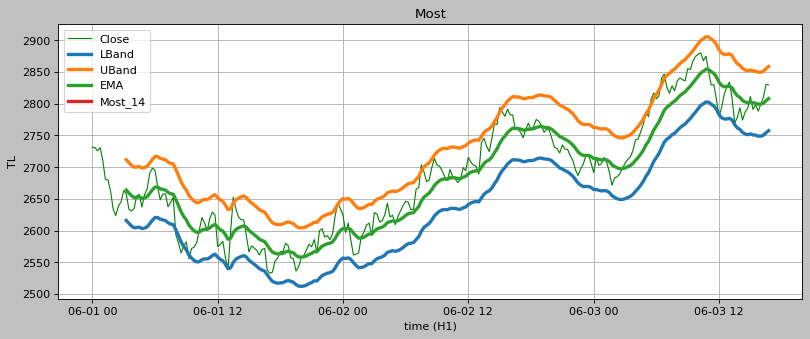

In [ ]:
xlim_min = 10
xlim_max = 50
des_df_tester = df_tester[xlim_min:xlim_max].describe()
ylim_min = des_df_tester["Close"]["min"]
ylim_max = des_df_tester["Close"]["max"] * 1.025

figure(num=None, figsize = (12, 10), dpi=80, facecolor='silver', edgecolor='gray')

plt.subplot(2, 1, 1)
plt.plot(df_tester["Open Time"], df_tester['Close'], linewidth=1.0, color="green")
plt.plot(df_tester["Open Time"], df_tester[['LBand', 'UBand', 'EMA_14', "Most_14"]], linewidth=3.0)
plt.xlabel('time (H1)')
plt.ylabel('TL')
plt.legend(['Close', 'LBand', 'UBand', 'EMA', 'Most_14'])
plt.title('Most')
plt.grid(True)


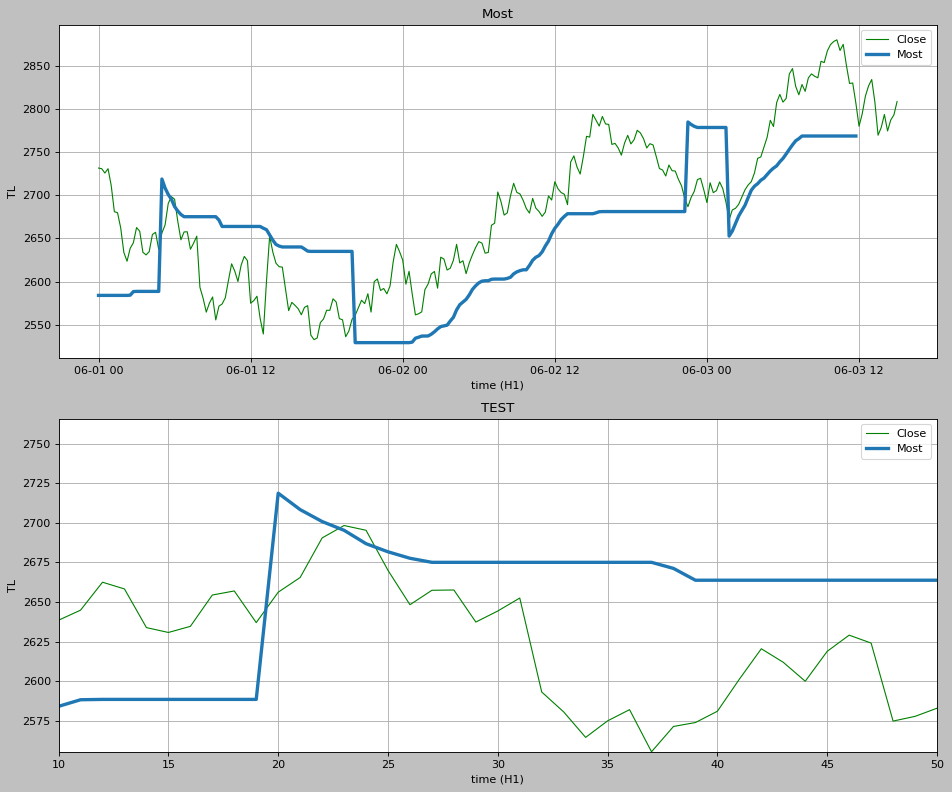

In [ ]:
xlim_min = 10
xlim_max = 50
des_df_tester = df_tester[xlim_min:xlim_max].describe()
ylim_min = des_df_tester["Close"]["min"]
ylim_max = des_df_tester["Close"]["max"] * 1.025

figure(num=None, figsize = (12, 10), dpi=80, facecolor='silver', edgecolor='gray')

plt.subplot(2, 1, 1)
plt.plot(df_tester["Open Time"], df_tester['Close'], linewidth=1.0, color="green")
plt.plot(df_tester["Open Time"], df_tester[['Most_14']], linewidth=3.0)
plt.xlabel('time (H1)')
plt.ylabel('TL')
plt.legend(['Close', 'Most'])
plt.title('Most')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_tester['Close'], linewidth=1.0, color="green")
plt.plot(df_tester[['Most_14']], linewidth=3.0)
plt.xlabel('time (H1)')
plt.ylabel('TL')
plt.legend(['Close', 'Most'])
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.title('TEST')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
array = np.array([1,2,3,4,5])
array

array([1, 2, 3, 4, 5])

In [ ]:
array = array.astype("float")
for key,i in enumerate(array):
  if i == 3:
    array[key] = np.nan
array

array([ 1.,  2., nan,  4.,  5.])

# **Helper Functions**

In [ ]:
def binanceDataFrame(klines):
  df = pd.DataFrame(klines.reshape(-1,12), dtype=float, columns=['Open Time',
                                                                 'Open',
                                                                 'High',
                                                                 'Low',
                                                                 'Close',
                                                                 'Volume',
                                                                 'Close Time',
                                                                 'Quote asset volume',
                                                                 'Number of trades',
                                                                 'Taker buy base asset volume',
                                                                 'Taker buy quote asset volume',
                                                                 'Can be ignored']);

  df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
  df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

  return df

In [ ]:
def date_to_miliseconds(date_str):
  epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
  d = dateparser.parse(date_str)
  if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
    d = d.replace(tzinfo=pytz.utc)

  #return difference in time
  return int((d - epoch).total_seconds()*1000.0)

In [ ]:
def interval_to_miliseconds(interval):
  ms = None
  seconds_per_unit = {
      "m": 60,
      "h": 60 * 60,
      "d": 24 * 60 * 60,
      "w": 7 * 24 * 60 * 60,
  }

  unit = interval[-1]
  if unit in seconds_per_unit:
    try:
      ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
    except:
      pass

  return ms

In [ ]:
def get_historical_klines(symbol, interval, start_str, end_str=None):
  output_data=[]
  limit=500
  timeFrame = interval_to_miliseconds(interval)
  start_ts = date_to_miliseconds(start_str)
  end_ts = None
  if end_str:
    end_ts = date_to_miliseconds(end_str)
  
  idx = 0
  symbol_existed = False
  while True:
    #fetch
    temp_data = client.get_klines(symbol = symbol, 
                                  interval = interval, 
                                  limit = limit, 
                                  startTime = start_ts, 
                                  endTime = end_ts)
    
    if not symbol_existed and len(temp_data):
      symbol_existed = True

    if symbol_existed:
      output_data += temp_data

      start_ts = temp_data[len(temp_data) - 1][0] + timeFrame

    idx += 1

    if len(temp_data)<limit:
      break

    if idx % 3 == 0:
      time.sleep(1)

  return output_data

# **Client**

In [ ]:
api_key = "Key"
api_secret = "Secret Key"
client = Client(api_key, api_secret)

# **Geting Datas**

In [ ]:
%%time
symbol = "ETHTRY"
start = "1 Jan, 2021"
interval = Client.KLINE_INTERVAL_1DAY
klines = get_historical_klines(symbol, interval, start)
klines = np.array(klines)
df_ETHTRY_1DAY = binanceDataFrame(klines)

CPU times: user 12.7 ms, sys: 156 µs, total: 12.9 ms
Wall time: 244 ms


In [ ]:
df_ETHTRY_1DAY

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Can be ignored
0,2021-01-01,5521.42,5587.00,5390.31,5448.45,766.388980,2021-01-01 23:59:59.999,4.200390e+06,2737.0,311.173520,1.707059e+06,0.0
1,2021-01-02,5453.16,5850.91,5365.83,5738.29,2455.181890,2021-01-02 23:59:59.999,1.387925e+07,7504.0,1167.240960,6.614952e+06,0.0
2,2021-01-03,5740.00,7400.15,5705.73,7181.84,4685.207080,2021-01-03 23:59:59.999,3.150230e+07,15366.0,2383.636780,1.599079e+07,0.0
3,2021-01-04,7206.02,12000.00,6760.00,7790.54,7260.737680,2021-01-04 23:59:59.999,5.515849e+07,24457.0,3571.769810,2.711419e+07,0.0
4,2021-01-05,7787.03,8446.06,7374.69,8100.00,5373.831680,2021-01-05 23:59:59.999,4.253387e+07,20972.0,2853.364840,2.261218e+07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
148,2021-05-29,20800.00,22148.00,19174.00,19756.00,15340.881051,2021-05-29 23:59:59.999,3.161116e+08,33558.0,7506.972237,1.546927e+08,0.0
149,2021-05-30,19751.00,21400.00,18950.00,20649.00,13675.698041,2021-05-30 23:59:59.999,2.833055e+08,31936.0,6834.740198,1.416089e+08,0.0
150,2021-05-31,20617.00,22995.00,19713.00,22870.00,17145.140249,2021-05-31 23:59:59.999,3.698885e+08,39609.0,8915.681906,1.926327e+08,0.0
151,2021-06-01,22870.00,23117.00,21610.00,22521.00,15774.137696,2021-06-01 23:59:59.999,3.502035e+08,35871.0,7526.526008,1.671424e+08,0.0


In [ ]:
%%time
symbol = "ETHTRY"
start = "19 May, 2021"
interval = Client.KLINE_INTERVAL_1HOUR
klines = get_historical_klines(symbol, interval, start)
klines = np.array(klines)
df_ETHTRY_1HOUR = binanceDataFrame(klines)

CPU times: user 19.4 ms, sys: 1.19 ms, total: 20.6 ms
Wall time: 256 ms


In [ ]:
df_ETHTRY_1HOUR

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Can be ignored
0,2021-05-19 00:00:00,28443.0,28877.0,28200.0,28201.0,265.036428,2021-05-19 00:59:59.999,7.558680e+06,732.0,148.406139,4.231712e+06,0.0
1,2021-05-19 01:00:00,28201.0,28235.0,26839.0,27114.0,712.174640,2021-05-19 01:59:59.999,1.952786e+07,1888.0,241.570229,6.625651e+06,0.0
2,2021-05-19 02:00:00,27028.0,27470.0,26350.0,26353.0,658.898486,2021-05-19 02:59:59.999,1.774446e+07,1571.0,264.595583,7.125078e+06,0.0
3,2021-05-19 03:00:00,26370.0,26701.0,25985.0,26247.0,800.029556,2021-05-19 03:59:59.999,2.108984e+07,1722.0,393.954575,1.039470e+07,0.0
4,2021-05-19 04:00:00,26297.0,26540.0,24391.0,24958.0,1524.927027,2021-05-19 04:59:59.999,3.846092e+07,3594.0,784.332392,1.977786e+07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
351,2021-06-02 15:00:00,23720.0,23970.0,23716.0,23880.0,803.067092,2021-06-02 15:59:59.999,1.915310e+07,2176.0,386.407825,9.217607e+06,0.0
352,2021-06-02 16:00:00,23880.0,23966.0,23454.0,23578.0,1026.916797,2021-06-02 16:59:59.999,2.438060e+07,2400.0,466.456238,1.107093e+07,0.0
353,2021-06-02 17:00:00,23581.0,23701.0,23451.0,23672.0,475.999316,2021-06-02 17:59:59.999,1.123031e+07,1519.0,224.682326,5.300066e+06,0.0
354,2021-06-02 18:00:00,23672.0,23750.0,23540.0,23722.0,371.459784,2021-06-02 18:59:59.999,8.789998e+06,1354.0,187.283712,4.432451e+06,0.0


In [ ]:
df_ETHTRY_1HOUR.describe()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Can be ignored
count,356.000000,356.000000,356.000000,356.000000,356.000000,3.560000e+02,356.00000,356.000000,3.560000e+02,356.0
mean,21744.247191,22078.511236,21321.533708,21728.530899,902.118640,1.933634e+07,2042.30618,445.363378,9.534924e+06,0.0
std,1914.386130,1885.380092,1955.088797,1883.398985,558.461225,1.121987e+07,1270.01927,287.474385,5.749021e+06,0.0
min,15935.000000,16731.000000,14999.000000,15957.000000,43.404504,1.027608e+06,160.00000,7.909469,1.872665e+05,0.0
25%,20572.250000,20922.750000,20085.750000,20572.000000,557.390781,1.220795e+07,1283.00000,267.884582,5.866675e+06,0.0
50%,21903.500000,22232.000000,21549.500000,21916.000000,755.727441,1.639808e+07,1743.00000,373.186486,8.144136e+06,0.0
75%,23119.500000,23349.250000,22715.250000,23131.500000,1091.004233,2.328130e+07,2475.00000,547.781096,1.190236e+07,0.0
max,28443.000000,28877.000000,28200.000000,28201.000000,4195.093819,8.319780e+07,10570.00000,2235.771394,4.426767e+07,0.0


# **Preporcesing**

In [ ]:
df_ETHTRY_1HOUR = df_ETHTRY_1HOUR.drop(columns=['Quote asset volume','Taker buy base asset volume','Taker buy quote asset volume','Can be ignored','Close Time'])

In [ ]:
df_ETHTRY_1HOUR

,Open Time,Open,High,Low,Close,Volume,Number of trades
0,2021-05-19 00:00:00,28443.0,28877.0,28200.0,28201.0,265.036428,732.0
1,2021-05-19 01:00:00,28201.0,28235.0,26839.0,27114.0,712.174640,1888.0
2,2021-05-19 02:00:00,27028.0,27470.0,26350.0,26353.0,658.898486,1571.0
3,2021-05-19 03:00:00,26370.0,26701.0,25985.0,26247.0,800.029556,1722.0
4,2021-05-19 04:00:00,26297.0,26540.0,24391.0,24958.0,1524.927027,3594.0
...,...,...,...,...,...,...,...
351,2021-06-02 15:00:00,23720.0,23970.0,23716.0,23880.0,803.067092,2176.0
352,2021-06-02 16:00:00,23880.0,23966.0,23454.0,23578.0,1026.916797,2400.0
353,2021-06-02 17:00:00,23581.0,23701.0,23451.0,23672.0,475.999316,1519.0
354,2021-06-02 18:00:00,23672.0,23750.0,23540.0,23722.0,371.459784,1354.0


# **Adding Financial Indicators**

In [ ]:
windows = [2, 3, 5, 8, 13, 21, 55, 250, 500]

In [ ]:
%%time

for w in tqdm(windows):
  df_ETHTRY_1HOUR = moving_average(df_ETHTRY_1HOUR, w)
  df_ETHTRY_1HOUR = exponential_moving_average(df_ETHTRY_1HOUR, w)
  df_ETHTRY_1HOUR = momentum(df_ETHTRY_1HOUR,w)
  df_ETHTRY_1HOUR = bollinger_bands(df_ETHTRY_1HOUR,w)
  df_ETHTRY_1HOUR = stochastic_oscillator(df_ETHTRY_1HOUR,w)
  df_ETHTRY_1HOUR = relative_strength_index(df_ETHTRY_1HOUR,w)
  df_ETHTRY_1HOUR = common_channel_index(df_ETHTRY_1HOUR,w)
  df_ETHTRY_1HOUR = standart_deviation(df_ETHTRY_1HOUR,w)

100%|██████████| 9/9 [00:00<00:00, 31.29it/s]

CPU times: user 286 ms, sys: 8.23 ms, total: 294 ms
Wall time: 290 ms


In [ ]:
df_ETHTRY_1HOUR

,Open Time,Open,High,Low,Close,Volume,Number of trades,MA_2,EMA_2,Momentum_2,BollingerB_2,Bollinger%b_2,S0k_2,RSI_2,CCI_2,STD_2,MA_3,EMA_3,Momentum_3,BollingerB_3,Bollinger%b_3,S0k_3,RSI_3,CCI_3,STD_3,MA_5,EMA_5,Momentum_5,BollingerB_5,Bollinger%b_5,S0k_5,RSI_5,CCI_5,STD_5,MA_8,EMA_8,Momentum_8,BollingerB_8,Bollinger%b_8,S0k_8,...,S0k_13,RSI_13,CCI_13,STD_13,MA_21,EMA_21,Momentum_21,BollingerB_21,Bollinger%b_21,S0k_21,RSI_21,CCI_21,STD_21,MA_55,EMA_55,Momentum_55,BollingerB_55,Bollinger%b_55,S0k_55,RSI_55,CCI_55,STD_55,MA_250,EMA_250,Momentum_250,BollingerB_250,Bollinger%b_250,S0k_250,RSI_250,CCI_250,STD_250,MA_500,EMA_500,Momentum_500,BollingerB_500,Bollinger%b_500,S0k_500,RSI_500,CCI_500,STD_500
0,2021-05-19 00:00:00,28443.0,28877.0,28200.0,28201.0,265.036428,732.0,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,...,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN
1,2021-05-19 01:00:00,28201.0,28235.0,26839.0,27114.0,712.174640,1888.0,27657.5,27385.750000,NaN,0.111163,0.323223,0.196991,NaN,-0.707107,768.625071,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,...,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN
2,2021-05-19 02:00:00,27028.0,27470.0,26350.0,26353.0,658.898486,1571.0,26733.5,26670.769231,-1848.0,0.080514,0.323223,0.002679,NaN,-0.707107,538.108260,27222.666667,26834.428571,NaN,0.136472,0.265912,0.002679,NaN,-0.923011,928.780024,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,...,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN
3,2021-05-19 03:00:00,26370.0,26701.0,25985.0,26247.0,800.029556,1722.0,26300.0,26384.725000,-867.0,0.011400,0.323223,0.365922,NaN,-0.707107,74.953319,26571.333333,26521.133333,-1954.0,0.071196,0.328556,0.365922,NaN,-0.912058,472.942209,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,...,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN
4,2021-05-19 04:00:00,26297.0,26540.0,24391.0,24958.0,1524.927027,3594.0,25602.5,25429.644628,-1395.0,0.142402,0.323223,0.263844,NaN,-0.707107,911.460641,25852.666667,25714.354839,-2156.0,0.120160,0.211998,0.263844,NaN,-1.108088,776.614662,26574.6,26017.042654,NaN,0.179774,0.161617,0.263844,NaN,-1.308513,1194.356856,NaN,NaN,NaN,NaN,NaN,0.263844,...,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,2021-06-02 15:00:00,23720.0,23970.0,23716.0,23880.0,803.067092,2176.0,23798.0,23779.815595,495.0,0.019492,0.676777,0.645669,0.227317,0.707107,115.965512,23660.333333,23682.860310,705.0,0.042629,0.717792,0.645669,0.323286,0.962244,252.151410,23456.6,23529.553484,854.0,0.056533,0.819289,0.645669,0.401174,1.399904,331.518174,23320.000,23353.191455,764.0,0.054843,0.937862,0.645669,...,0.645669,0.468742,1.926038,447.992373,22715.904762,22891.541506,1914.0,0.103306,0.996059,0.645669,0.491046,2.039523,586.671450,22373.545455,22341.401168,2585.0,0.097873,1.187954,0.645669,0.5

In [ ]:
df_temp = pd.DataFrame()
df_temp["Current Open Time"] = df_ETHTRY_1HOUR["Open Time"]
df_temp["Current Open"] = df_ETHTRY_1HOUR["Open"]
df_temp["Current Close"] = df_ETHTRY_1HOUR["Close"]

In [ ]:
df_temp = df_temp.iloc[1:]

In [ ]:
df_temp = df_temp.reset_index(drop=True)
df_temp

,Current Open Time,Current Open,Current Close
0,2021-05-19 01:00:00,28201.0,27114.0
1,2021-05-19 02:00:00,27028.0,26353.0
2,2021-05-19 03:00:00,26370.0,26247.0
3,2021-05-19 04:00:00,26297.0,24958.0
4,2021-05-19 05:00:00,24955.0,24800.0
...,...,...,...
350,2021-06-02 15:00:00,23720.0,23880.0
351,2021-06-02 16:00:00,23880.0,23578.0
352,2021-06-02 17:00:00,23581.0,23672.0
353,2021-06-02 18:00:00,23672.0,23722.0


In [ ]:
cols = [c for c in df_ETHTRY_1HOUR.columns if c not in ['Open Time']]
df_temp[cols] = df_ETHTRY_1HOUR[cols]

In [ ]:
df_temp

,Current Open Time,Current Open,Current Close,Open,High,Low,Close,Volume,Number of trades,MA_2,EMA_2,Momentum_2,BollingerB_2,Bollinger%b_2,S0k_2,RSI_2,CCI_2,STD_2,MA_3,EMA_3,Momentum_3,BollingerB_3,Bollinger%b_3,S0k_3,RSI_3,CCI_3,STD_3,MA_5,EMA_5,Momentum_5,BollingerB_5,Bollinger%b_5,S0k_5,RSI_5,CCI_5,STD_5,MA_8,EMA_8,Momentum_8,BollingerB_8,...,S0k_13,RSI_13,CCI_13,STD_13,MA_21,EMA_21,Momentum_21,BollingerB_21,Bollinger%b_21,S0k_21,RSI_21,CCI_21,STD_21,MA_55,EMA_55,Momentum_55,BollingerB_55,Bollinger%b_55,S0k_55,RSI_55,CCI_55,STD_55,MA_250,EMA_250,Momentum_250,BollingerB_250,Bollinger%b_250,S0k_250,RSI_250,CCI_250,STD_250,MA_500,EMA_500,Momentum_500,BollingerB_500,Bollinger%b_500,S0k_500,RSI_500,CCI_500,STD_500
0,2021-05-19 01:00:00,28201.0,27114.0,28443.0,28877.0,28200.0,28201.0,265.036428,732.0,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN
1,2021-05-19 02:00:00,27028.0,26353.0,28201.0,28235.0,26839.0,27114.0,712.174640,1888.0,27657.5,27385.750000,NaN,0.111163,0.323223,0.196991,NaN,-0.707107,768.625071,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN
2,2021-05-19 03:00:00,26370.0,26247.0,27028.0,27470.0,26350.0,26353.0,658.898486,1571.0,26733.5,26670.769231,-1848.0,0.080514,0.323223,0.002679,NaN,-0.707107,538.108260,27222.666667,26834.428571,NaN,0.136472,0.265912,0.002679,NaN,-0.923011,928.780024,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN
3,2021-05-19 04:00:00,26297.0,24958.0,26370.0,26701.0,25985.0,26247.0,800.029556,1722.0,26300.0,26384.725000,-867.0,0.011400,0.323223,0.365922,NaN,-0.707107,74.953319,26571.333333,26521.133333,-1954.0,0.071196,0.328556,0.365922,NaN,-0.912058,472.942209,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN
4,2021-05-19 05:00:00,24955.0,24800.0,26297.0,26540.0,24391.0,24958.0,1524.927027,3594.0,25602.5,25429.644628,-1395.0,0.142402,0.323223,0.263844,NaN,-0.707107,911.460641,25852.666667,25714.354839,-2156.0,0.120160,0.211998,0.263844,NaN,-1.108088,776.614662,26574.6,26017.042654,NaN,0.179774,0.161617,0.263844,NaN,-1.308513,1194.356856,NaN,NaN,NaN,NaN,...,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,2021-06-02 15:00:00,23720.0,23880.0,23385.0,23825.0,23300.0,23716.0,643.687417,2168.0,23550.5,23579.446785,541.0,0.039753,0.676777,0.792381,0.944187,0.707107,234.052345,23425.333333,23485.720621,589.0,0.046573,0.766426,0.792381,0.884841,1.107417,272.745914,23285.8,23354.330226,692.0,0.047036,0.892781,0.792381,0.794277,1.593223,273.816910,23224.500,23202.674728,1117.0,0.039633,...,0.792381,0.645588,1.749471,433.447776,22624.761905,22792.695657,1882.0,0.096159,1.001584,0.792381,0.609399,1.921942,543.896121,22326.545455,22284.415864,2687.0,0

In [ ]:
df_ETHTRY_1HOUR = df_temp

In [ ]:
df_ETHTRY_1HOUR

,Current Open Time,Current Open,Current Close,Open,High,Low,Close,Volume,Number of trades,MA_2,EMA_2,Momentum_2,BollingerB_2,Bollinger%b_2,S0k_2,RSI_2,CCI_2,STD_2,MA_3,EMA_3,Momentum_3,BollingerB_3,Bollinger%b_3,S0k_3,RSI_3,CCI_3,STD_3,MA_5,EMA_5,Momentum_5,BollingerB_5,Bollinger%b_5,S0k_5,RSI_5,CCI_5,STD_5,MA_8,EMA_8,Momentum_8,BollingerB_8,...,S0k_13,RSI_13,CCI_13,STD_13,MA_21,EMA_21,Momentum_21,BollingerB_21,Bollinger%b_21,S0k_21,RSI_21,CCI_21,STD_21,MA_55,EMA_55,Momentum_55,BollingerB_55,Bollinger%b_55,S0k_55,RSI_55,CCI_55,STD_55,MA_250,EMA_250,Momentum_250,BollingerB_250,Bollinger%b_250,S0k_250,RSI_250,CCI_250,STD_250,MA_500,EMA_500,Momentum_500,BollingerB_500,Bollinger%b_500,S0k_500,RSI_500,CCI_500,STD_500
0,2021-05-19 01:00:00,28201.0,27114.0,28443.0,28877.0,28200.0,28201.0,265.036428,732.0,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001477,NaN,NaN,NaN
1,2021-05-19 02:00:00,27028.0,26353.0,28201.0,28235.0,26839.0,27114.0,712.174640,1888.0,27657.5,27385.750000,NaN,0.111163,0.323223,0.196991,NaN,-0.707107,768.625071,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196991,NaN,NaN,NaN
2,2021-05-19 03:00:00,26370.0,26247.0,27028.0,27470.0,26350.0,26353.0,658.898486,1571.0,26733.5,26670.769231,-1848.0,0.080514,0.323223,0.002679,NaN,-0.707107,538.108260,27222.666667,26834.428571,NaN,0.136472,0.265912,0.002679,NaN,-0.923011,928.780024,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002679,NaN,NaN,NaN
3,2021-05-19 04:00:00,26297.0,24958.0,26370.0,26701.0,25985.0,26247.0,800.029556,1722.0,26300.0,26384.725000,-867.0,0.011400,0.323223,0.365922,NaN,-0.707107,74.953319,26571.333333,26521.133333,-1954.0,0.071196,0.328556,0.365922,NaN,-0.912058,472.942209,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365922,NaN,NaN,NaN
4,2021-05-19 05:00:00,24955.0,24800.0,26297.0,26540.0,24391.0,24958.0,1524.927027,3594.0,25602.5,25429.644628,-1395.0,0.142402,0.323223,0.263844,NaN,-0.707107,911.460641,25852.666667,25714.354839,-2156.0,0.120160,0.211998,0.263844,NaN,-1.108088,776.614662,26574.6,26017.042654,NaN,0.179774,0.161617,0.263844,NaN,-1.308513,1194.356856,NaN,NaN,NaN,NaN,...,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263844,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,2021-06-02 15:00:00,23720.0,23880.0,23385.0,23825.0,23300.0,23716.0,643.687417,2168.0,23550.5,23579.446785,541.0,0.039753,0.676777,0.792381,0.944187,0.707107,234.052345,23425.333333,23485.720621,589.0,0.046573,0.766426,0.792381,0.884841,1.107417,272.745914,23285.8,23354.330226,692.0,0.047036,0.892781,0.792381,0.794277,1.593223,273.816910,23224.500,23202.674728,1117.0,0.039633,...,0.792381,0.645588,1.749471,433.447776,22624.761905,22792.695657,1882.0,0.096159,1.001584,0.792381,0.609399,1.921942,543.896121,22326.545455,22284.415864,2687.0,0

# **Define Train Data**

In [ ]:
X = df_ETHTRY_1HOUR.drop(['Current Open Time', 'Current Close', 'Number of trades'], axis=1)
y = df_ETHTRY_1HOUR['Current Close']

# **Clean Train Data**

In [ ]:
X = X[max(windows)+1:]
y = y[max(windows)+1:]
X.fillna(value=0, inplace=True)
X.replace([np.inf, -np.inf], 0, inplace=True)

,Current Open,Open,High,Low,Close,Volume,MA_2,EMA_2,Momentum_2,BollingerB_2,Bollinger%b_2,S0k_2,RSI_2,CCI_2,STD_2,MA_3,EMA_3,Momentum_3,BollingerB_3,Bollinger%b_3,S0k_3,RSI_3,CCI_3,STD_3,MA_5,EMA_5,Momentum_5,BollingerB_5,Bollinger%b_5,S0k_5,RSI_5,CCI_5,STD_5,MA_8,EMA_8,Momentum_8,BollingerB_8,Bollinger%b_8,S0k_8,RSI_8,...,S0k_13,RSI_13,CCI_13,STD_13,MA_21,EMA_21,Momentum_21,BollingerB_21,Bollinger%b_21,S0k_21,RSI_21,CCI_21,STD_21,MA_55,EMA_55,Momentum_55,BollingerB_55,Bollinger%b_55,S0k_55,RSI_55,CCI_55,STD_55,MA_250,EMA_250,Momentum_250,BollingerB_250,Bollinger%b_250,S0k_250,RSI_250,CCI_250,STD_250,MA_500,EMA_500,Momentum_500,BollingerB_500,Bollinger%b_500,S0k_500,RSI_500,CCI_500,STD_500


In [ ]:
X_backup = X
X

,Current Open,Open,High,Low,Close,Volume,MA_2,EMA_2,Momentum_2,BollingerB_2,Bollinger%b_2,S0k_2,RSI_2,CCI_2,STD_2,MA_3,EMA_3,Momentum_3,BollingerB_3,Bollinger%b_3,S0k_3,RSI_3,CCI_3,STD_3,MA_5,EMA_5,Momentum_5,BollingerB_5,Bollinger%b_5,S0k_5,RSI_5,CCI_5,STD_5,MA_8,EMA_8,Momentum_8,BollingerB_8,Bollinger%b_8,S0k_8,RSI_8,...,S0k_13,RSI_13,CCI_13,STD_13,MA_21,EMA_21,Momentum_21,BollingerB_21,Bollinger%b_21,S0k_21,RSI_21,CCI_21,STD_21,MA_55,EMA_55,Momentum_55,BollingerB_55,Bollinger%b_55,S0k_55,RSI_55,CCI_55,STD_55,MA_250,EMA_250,Momentum_250,BollingerB_250,Bollinger%b_250,S0k_250,RSI_250,CCI_250,STD_250,MA_500,EMA_500,Momentum_500,BollingerB_500,Bollinger%b_500,S0k_500,RSI_500,CCI_500,STD_500


# **Scaling**

In [ ]:
%%time
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

ValueError: ignored

In [ ]:
X

,Current Open,Open,High,Low,Close,Volume,MA_2,EMA_2,Momentum_2,BollingerB_2,Bollinger%b_2,S0k_2,RSI_2,CCI_2,STD_2,MA_3,EMA_3,Momentum_3,BollingerB_3,Bollinger%b_3,S0k_3,RSI_3,CCI_3,STD_3,MA_5,EMA_5,Momentum_5,BollingerB_5,Bollinger%b_5,S0k_5,RSI_5,CCI_5,STD_5,MA_8,EMA_8,Momentum_8,BollingerB_8,Bollinger%b_8,S0k_8,RSI_8,...,S0k_13,RSI_13,CCI_13,STD_13,MA_21,EMA_21,Momentum_21,BollingerB_21,Bollinger%b_21,S0k_21,RSI_21,CCI_21,STD_21,MA_55,EMA_55,Momentum_55,BollingerB_55,Bollinger%b_55,S0k_55,RSI_55,CCI_55,STD_55,MA_250,EMA_250,Momentum_250,BollingerB_250,Bollinger%b_250,S0k_250,RSI_250,CCI_250,STD_250,MA_500,EMA_500,Momentum_500,BollingerB_500,Bollinger%b_500,S0k_500,RSI_500,CCI_500,STD_500


# **Split Data For Training**

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.35, shuffle = False)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, test_size=0.3, shuffle = True)
print("Train", X_train.shape, y_train.shape)
print("Valid", X_valid.shape, y_valid.shape)
print("Test", X_test.shape, y_test.shape)

ValueError: ignored

In [ ]:
X_train

NameError: ignored

# **Train**

## **Catboost**

### **Model Definition**

In [ ]:
# https://catboost.ai/docs/search/?query=catboostregressor
model = CatBoostRegressor(iterations=20_000,
                          verbose=100, 
                          # boosting_type = 'Ordered',
                          early_stopping_rounds=200,
                          loss_function = 'RMSE',
                          custom_metric = 'MAE',
                          task_type = 'CPU'
                          )

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model = True)

Learning rate set to 0.007461
0:	learn: 1978.2733191	test: 2023.6329323	best: 2023.6329323 (0)	total: 25.5ms	remaining: 8m 30s
100:	learn: 1025.7037567	test: 1056.4159947	best: 1056.4159947 (100)	total: 2.56s	remaining: 8m 23s
200:	learn: 549.5008339	test: 571.1244979	best: 571.1244979 (200)	total: 5.06s	remaining: 8m 18s
300:	learn: 312.3286779	test: 329.7924676	best: 329.7924676 (300)	total: 7.6s	remaining: 8m 17s
400:	learn: 197.5485696	test: 214.8442144	best: 214.8442144 (400)	total: 10.1s	remaining: 8m 13s
500:	learn: 145.7233418	test: 165.1850597	best: 165.1850597 (500)	total: 12.6s	remaining: 8m 9s
600:	learn: 123.4966087	test: 144.8791316	best: 144.8791316 (600)	total: 15.1s	remaining: 8m 7s
700:	learn: 113.2267984	test: 136.2884669	best: 136.2884669 (700)	total: 17.6s	remaining: 8m 4s
800:	learn: 107.8285055	test: 132.3100990	best: 132.3100990 (800)	total: 20.1s	remaining: 8m 2s
900:	learn: 104.2508017	test: 130.2144279	best: 130.2144279 (900)	total: 22.6s	remaining: 7m 59s
10

In [ ]:
model.save_model('base_model_127.56.model')

# **Model Testing**

In [ ]:
model_use = CatBoostRegressor()
model_use.load_model('base_model_127.56.model')

CatBoostError: ignored

In [ ]:
%%time
y_pred = model_use.predict(X_train)
mse_train = mean_squared_error(y_train,y_pred)
print('mean_squared_error train', math.sqrt(mse_train))
mae_train = mean_absolute_error(y_train,y_pred)
print('mean_absolute_error train', mae_train)

y_pred = model_use.predict(X_valid)
mse_valid = mean_squared_error(y_valid,y_pred)
print('mean_squared_error valid', math.sqrt(mse_valid))
mae_valid = mean_absolute_error(y_valid,y_pred)
print('mean_absolute_error valid', mae_valid)

y_pred = model_use.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred)
print('mean_squared_error test', math.sqrt(mse_test))
mae_test = mean_absolute_error(y_test,y_pred)
print('mean_absolute_error test', mae_test)

mean_squared_error train 77.90658713836422
mean_absolute_error train 60.22987306169754
mean_squared_error valid 127.43779162897013
mean_absolute_error valid 93.42776363532509
mean_squared_error test 9178.245790325893
mean_absolute_error test 7073.491585104569
CPU times: user 35.6 ms, sys: 2.01 ms, total: 37.7 ms
Wall time: 27.2 ms


# **Strategy Testing**

In [ ]:
%%time 
X_test_unscaled = scaler.inverse_transform(X_test)
X_test_unscaled = pd.DataFrame(X_test_unscaled, columns=X_test.columns)

CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 1.21 ms


In [ ]:
X_test_unscaled['Pred_Close'] = y_pred
X_test_unscaled['Current Close'] = y_test.values
X_test_unscaled = X_test_unscaled[['Current Open', 'Current Close', 'Pred_Close',  'MA_2']]

In [ ]:
X_test_unscaled['Diff'] = X_test_unscaled['Current Close'] - X_test_unscaled['Pred_Close']

In [ ]:
X_test_unscaled.sort_values("Diff", ascending= False)

,Current Open,Current Close,Pred_Close,MA_2,Diff
828,36175.0,36441.0,17406.246468,36086.0,19034.753532
817,35475.0,35990.0,17224.948314,35117.0,18765.051686
827,36009.0,36163.0,17414.445398,35916.0,18748.554602
836,35017.0,36024.0,17278.780234,34927.0,18745.219766
819,35815.0,36046.0,17337.837371,35897.0,18708.162629
...,...,...,...,...,...
4,16483.0,16515.0,16429.594372,16424.0,85.405628
0,16550.0,16580.0,16506.336998,16499.0,73.663002
11,16894.0,16766.0,16708.827294,16922.5,57.172706
14,16636.0,16486.0,16449.392500,16652.5,36.607500


In [ ]:
X_test_unscaled.describe()

,Current Open,Current Close,Pred_Close,MA_2,Diff
count,412.000000,412.000000,412.000000,412.000000,412.000000
mean,18560.726481,18571.411238,18580.061987,18555.775983,-8.650749
std,6745.157532,6759.392311,6685.805249,6744.284234,330.759203
min,10332.880000,10226.000000,10678.314722,10295.315000,-1184.164345
25%,13454.000000,13441.500000,13425.051194,13459.125000,-152.991633
50%,17148.500000,17180.000000,17163.561108,17137.250000,-4.224629
75%,20884.500000,20787.000000,20910.828495,20790.875000,105.334645
max,36009.000000,36163.000000,35621.225983,35916.000000,3497.945381


In [ ]:
X_plot = pd.DataFrame(columns= X_test_unscaled.columns)
for index1, row1 in X_backup.iterrows():
  for index2, row2 in X_test_unscaled.iterrows():
    if row1["Current Open"] == row2["Current Open"]:
      if row1["MA_2"] == row2["MA_2"]:
        X_plot = X_plot.append(X_test_unscaled.iloc[index2])

In [ ]:
X_plot = X_plot.reset_index(drop=True)
X_plot 

,Current Open,Current Close,Pred_Close,MA_2,Diff
0,13327.05,13143.76,13200.208479,13413.590,-56.448479
1,13167.99,13071.88,13048.654440,13240.470,23.225560
2,12690.74,12514.63,12524.523640,12758.245,-9.893640
3,12452.79,12646.49,12257.404193,12367.655,389.085807
4,12308.56,12105.74,12145.707522,12420.520,-39.967522
...,...,...,...,...,...
399,29455.00,29030.00,28856.667439,29371.000,173.332561
400,29030.00,29400.00,28700.466896,29236.000,699.533104
401,29390.00,29120.00,29036.433842,29215.000,83.566158
402,27905.00,28233.00,28025.395163,28116.500,207.604837


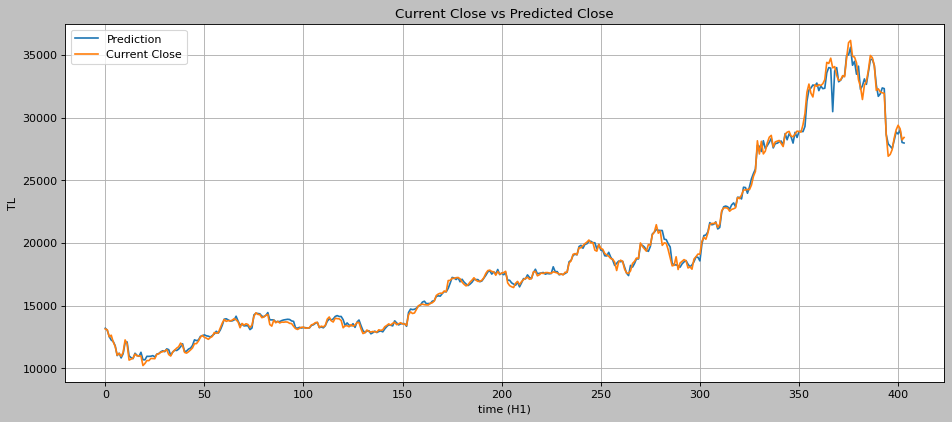

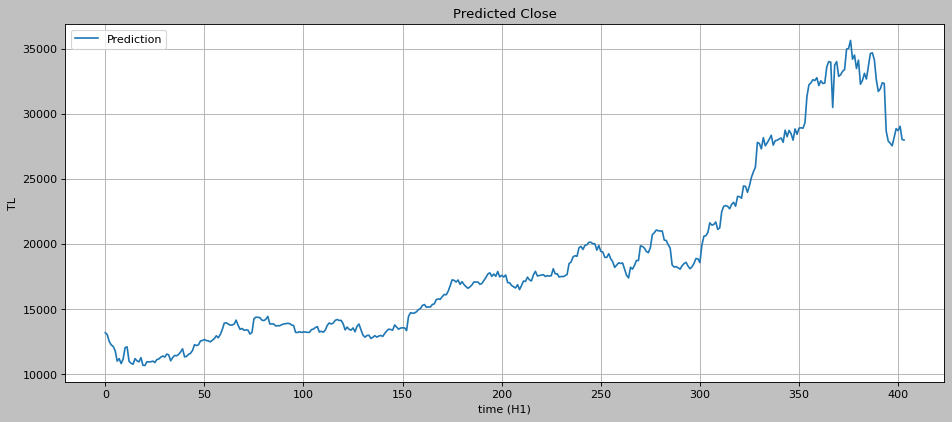

In [ ]:
figure(num=None, figsize = (12, 10), dpi=80, facecolor='silver', edgecolor='gray')

plt.subplot(2, 1, 1)
plt.plot(X_plot[['Pred_Close', 'Current Close']])
plt.xlabel('time (H1)')
plt.ylabel('TL')
plt.legend(['Prediction', 'Current Close'])
plt.title('Current Close vs Predicted Close')
plt.grid(True)

plt.tight_layout()
plt.show()

figure(num=None, figsize = (12, 10), dpi=80, facecolor='silver', edgecolor='gray')

plt.subplot(2, 1, 2)
plt.plot(X_plot[['Pred_Close']])
plt.xlabel('time (H1)')
plt.ylabel('TL')
plt.legend(['Prediction'])
plt.title('Predicted Close')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
%%time
symbol = "ETHTRY"
start = "1 May, 2021"
interval = Client.KLINE_INTERVAL_1HOUR
klines = get_historical_klines(symbol, interval, start)
klines = np.array(klines)
df_ETHTRY_19052021 = binanceDataFrame(klines)

CPU times: user 30.8 ms, sys: 996 µs, total: 31.8 ms
Wall time: 333 ms


In [ ]:
df_ETHTRY_19052021 = df_ETHTRY_19052021.drop(columns=['Quote asset volume','Taker buy base asset volume','Taker buy quote asset volume','Can be ignored','Close Time', 'Open Time'])

In [ ]:
%%time
windows = [2, 3, 5, 8, 13, 21, 55, 250, 500]
for w in tqdm(windows):
  df_ETHTRY_19052021 = moving_average(df_ETHTRY_19052021, w)
  df_ETHTRY_19052021 = exponential_moving_average(df_ETHTRY_19052021, w)
  df_ETHTRY_19052021 = momentum(df_ETHTRY_19052021,w)
  df_ETHTRY_19052021 = bollinger_bands(df_ETHTRY_19052021,w)
  df_ETHTRY_19052021 = stochastic_oscillator(df_ETHTRY_19052021,w)
  df_ETHTRY_19052021 = relative_strength_index(df_ETHTRY_19052021,w)
  df_ETHTRY_19052021 = common_channel_index(df_ETHTRY_19052021,w)
  df_ETHTRY_19052021 = standart_deviation(df_ETHTRY_19052021,w)

100%|██████████| 9/9 [00:00<00:00, 26.73it/s]

CPU times: user 341 ms, sys: 907 µs, total: 342 ms
Wall time: 341 ms


In [ ]:
df_ETHTRY_19052021

,Open,High,Low,Close,Volume,Number of trades,MA_2,EMA_2,Momentum_2,BollingerB_2,Bollinger%b_2,S0k_2,RSI_2,CCI_2,STD_2,MA_3,EMA_3,Momentum_3,BollingerB_3,Bollinger%b_3,S0k_3,RSI_3,CCI_3,STD_3,MA_5,EMA_5,Momentum_5,BollingerB_5,Bollinger%b_5,S0k_5,RSI_5,CCI_5,STD_5,MA_8,EMA_8,Momentum_8,BollingerB_8,Bollinger%b_8,S0k_8,RSI_8,...,S0k_13,RSI_13,CCI_13,STD_13,MA_21,EMA_21,Momentum_21,BollingerB_21,Bollinger%b_21,S0k_21,RSI_21,CCI_21,STD_21,MA_55,EMA_55,Momentum_55,BollingerB_55,Bollinger%b_55,S0k_55,RSI_55,CCI_55,STD_55,MA_250,EMA_250,Momentum_250,BollingerB_250,Bollinger%b_250,S0k_250,RSI_250,CCI_250,STD_250,MA_500,EMA_500,Momentum_500,BollingerB_500,Bollinger%b_500,S0k_500,RSI_500,CCI_500,STD_500
0,22796.0,22835.0,22717.0,22815.0,138.459761,994.0,NaN,NaN,NaN,NaN,NaN,0.830508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830508,NaN,...,0.830508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830508,NaN,NaN,NaN
1,22800.0,23057.0,22689.0,23057.0,248.669543,1062.0,22936.0,22996.500000,NaN,0.029843,0.676777,1.000000,1.000000,0.707107,171.119841,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
2,23038.0,23389.0,23017.0,23211.0,339.465661,1298.0,23134.0,23145.000000,396.0,0.018828,0.676777,0.521505,1.000000,0.707107,108.894444,23027.666667,23110.428571,NaN,0.034675,0.729599,0.521505,1.000000,1.084397,199.622978,NaN,NaN,NaN,NaN,NaN,0.521505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521505,NaN,...,0.521505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.521505,NaN,NaN,NaN
3,23212.0,23387.0,23192.0,23310.0,175.483386,646.0,23260.5,23256.375000,253.0,0.012038,0.676777,0.605128,0.436090,0.707107,70.003571,23192.666667,23216.866667,495.0,0.021988,0.730079,0.605128,0.558638,0.801049,127.492483,NaN,NaN,NaN,NaN,NaN,0.605128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605128,NaN,...,0.605128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605128,NaN,NaN,NaN
4,23312.0,23354.0,23229.0,23329.0,100.842873,640.0,23319.5,23304.991736,118.0,0.002305,0.676777,0.800000,0.321203,0.707107,13.435029,23283.333333,23274.741935,272.0,0.010885,0.680191,0.800000,0.470776,0.646017,63.358767,23144.4,23234.090047,NaN,0.036873,0.716307,0.800000,0.581290,0.853970,213.353697,NaN,NaN,NaN,NaN,NaN,0.800000,NaN,...,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,28339.0,28700.0,28101.0,28576.0,659.547087,2168.0,28473.0,28531.633353,-19.0,0.020463,0.676777,0.792988,0.618440,0.707107,145.663997,28513.666667,28519.027658,-192.0,0.017505,0.624885,0.792988,0.420787,-0.231124,124.781142,28508.4,28520.640337,668.0,0.029303,0.580922,0.792988,0.333429,0.148214,208.842764,28429.625,28556.111571,-874.0,0.039170,0.631445,0.792988,0.340833,...,0.792988,0.379770,-0.557399,482.957316,28669.523810,28632.515826,1508.0,0.077590,0.457957,0.792988,0.407893,-0.289450,556.120636,28935.218182,29262.842168,-2733.0,0.139764,0.411175,0.792988,0.404234,-0.476423,1011.025345,32363.084,31084.477233,-858.0,0.274272,0.073

In [ ]:
df_ETHTRY_19052021_last = pd.DataFrame(columns=df_ETHTRY_19052021.columns)
df_ETHTRY_19052021_last = df_ETHTRY_19052021_last.append(df_ETHTRY_19052021.iloc[(len(df_ETHTRY_19052021)-1)])

In [ ]:
df_ETHTRY_19052021_last['Current Open'] = df_ETHTRY_19052021["Open"][(len(df_ETHTRY_19052021)-2)]
cols = [c for c in df_ETHTRY_19052021_last.columns]
cols = cols[-1:] + cols[:-1]

In [ ]:
df_ETHTRY_19052021_last = df_ETHTRY_19052021_last[cols]
df_ETHTRY_19052021_last

,Current Open,Open,High,Low,Close,Volume,Number of trades,MA_2,EMA_2,Momentum_2,BollingerB_2,Bollinger%b_2,S0k_2,RSI_2,CCI_2,STD_2,MA_3,EMA_3,Momentum_3,BollingerB_3,Bollinger%b_3,S0k_3,RSI_3,CCI_3,STD_3,MA_5,EMA_5,Momentum_5,BollingerB_5,Bollinger%b_5,S0k_5,RSI_5,CCI_5,STD_5,MA_8,EMA_8,Momentum_8,BollingerB_8,Bollinger%b_8,S0k_8,...,S0k_13,RSI_13,CCI_13,STD_13,MA_21,EMA_21,Momentum_21,BollingerB_21,Bollinger%b_21,S0k_21,RSI_21,CCI_21,STD_21,MA_55,EMA_55,Momentum_55,BollingerB_55,Bollinger%b_55,S0k_55,RSI_55,CCI_55,STD_55,MA_250,EMA_250,Momentum_250,BollingerB_250,Bollinger%b_250,S0k_250,RSI_250,CCI_250,STD_250,MA_500,EMA_500,Momentum_500,BollingerB_500,Bollinger%b_500,S0k_500,RSI_500,CCI_500,STD_500
431,28625.0,28316.0,28532.0,27959.0,28250.0,177.543699,815.0,28285.0,28309.180659,-375.0,0.007,0.323223,0.507853,0.316091,-0.707107,49.497475,28398.333333,28362.501729,-501.0,0.028085,0.314021,0.507853,0.389469,-0.95711,199.394918,28504.4,28424.052412,-120.0,0.029703,0.199523,0.507853,0.402424,-1.391221,211.663176,28531.875,28476.915086,17.0,0.027479,0.140473,0.507853,...,0.507853,0.415245,-0.748072,370.769816,28750.52381,28579.441859,-143.0,0.064606,0.230532,0.507853,0.427097,-1.087673,464.363071,28754.981818,29156.626288,-2137.0,0.115539,0.348003,0.507853,0.412585,-0.631276,830.578234,32344.848,30999.932885,-2073.0,0.277716,0.04414,0.507853,0.313016,-1.743315,2245.671419,NaN,NaN,NaN,NaN,NaN,0.507853,NaN,NaN,NaN


In [ ]:
%%time
scaler = StandardScaler()
scaler.fit(df_ETHTRY_19052021_last)
df_ETHTRY_19052021_last = pd.DataFrame(scaler.transform(df_ETHTRY_19052021_last), columns=df_ETHTRY_19052021_last.columns)

CPU times: user 2.56 ms, sys: 996 µs, total: 3.55 ms
Wall time: 6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [ ]:
df_ETHTRY_19052021_last_pred = model_use.predict(df_ETHTRY_19052021_last)

In [ ]:
df_ETHTRY_19052021_last_pred

array([18019.76811216])